# EGABA and neuronal gain

### imports

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from IPython.display import Image, clear_output


### config

In [2]:
from src.config import shared
from neuron import h
shared.INIT_NEURON(reinit=False)

logger = logging.getLogger(__name__)

# if you want to see all output (including HOC output, set this to False)
ONLY_SHOW_IMAGES = True
if not ONLY_SHOW_IMAGES:
    clear_output = lambda wait=None: 1


libnrniv.dylib running as arm64
but /usr/local/lib/libmpi.dylib can only run as x86_64

05-23 23:07:22 settings   [settings.py:  82] DEBUG    	 imported style /Users/ccurrin/dev/chloride-dynamics-io-neuron/src/config/article.mplstyle
NEURON: RandomStream : a template cannot be redefined
 in ranstream.hoc near line 10
 begintemplate RandomStream
                          ^
        xopen("ranstream.hoc")
      execute1("{xopen("ra...")
    load_file("/Users/ccu...")
05-23 23:07:22 shared     [shared.py :  62] INFO     	 celsius=37.0 and v_init=-65.0


	1 
	1 
	1 
******************************************************************************
                         'usefulFns.hoc' loaded!                              
******************************************************************************


## Run for a given EGABA

In [3]:
from tqdm import tqdm
from src.iocurves.sim import do_run
import itertools

synapse_type = 1 # persistent # 0 for frequency-based

base_input = list(set(np.geomspace(1, 10, 9, dtype=int)))
exc_input = sorted(set(base_input + list(np.array(base_input)*10) + list(np.array(base_input)*100)+ list(np.array(base_input)*1000)))
# geometric input

inh_input = list(exc_input)
# exc_input=np.arange(0, 31, 6) # np.arange(0, 33, 3)
inh_input=np.arange(0, 22, 2) # np.arange(0, 22, 2)

egaba_list = np.arange(-50, -85, -5, dtype=int)
inh_input_locations = ["distal"]
loop_range = list(itertools.product(inh_input_locations, inh_input, exc_input, egaba_list))

results = {}
logging.getLogger().setLevel(logging.WARNING)
pbar = tqdm(loop_range)
for file_name, i_input, e_input, egaba in pbar:
    print()
    logger.warning("{:>10s} | {:>4s} | {:>4s} | {:5s}".format("location", "inh", "exc", "egaba"))
    logger.warning("{:>10s} | {:>4g} | {:>4g} | {:>3g}".format(file_name, i_input, e_input, egaba))

    result, save_name = do_run(file_name=file_name,
                                synapse_type=synapse_type,
                                synapse_numbers=(100, 100),
                                #    diam={'ldend': 1}, 
                                trials=1 if synapse_type==1 else 5,
                                save=True,
                                    syn_input={
                                        'ex': e_input,
                                        'in': i_input,
                                        },
                                subsample=None,
                                vm_egaba=(-65, egaba),
                                tstop=1000,
                                )

    results[save_name] = result
    clear_output()
    pbar.set_description("{:>8s} | {:>4g} | {:>4g} | {:>3g} -> {:>3g}".format(file_name, 
                                                i_input, e_input, egaba, 
                                                result[(1,"spikes")].iloc[-1]))


# proximal inhibitory input
inh_input=np.round(np.arange(0, 1.01, 0.1), 1)
inh_input_locations = ["proximal"]
loop_range = list(itertools.product(inh_input_locations, inh_input, exc_input, egaba_list))

pbar = tqdm(loop_range)
for file_name, i_input, e_input, egaba in pbar:
    result, save_name = do_run(file_name=file_name,
                                synapse_type=synapse_type,
                                synapse_numbers=(100, 100),
                                #    diam={'ldend': 1}, 
                                trials=1 if synapse_type==1 else 5,
                                save=True,
                                    syn_input={
                                        'ex': e_input,
                                        'in': i_input,
                                        },
                                subsample=None,
                                vm_egaba=(-65, egaba),
                                tstop=1000,
                                )

    results[save_name] = result
    clear_output()
    pbar.set_description("{:>8s} | {:>4g} | {:>4g} | {:>3g} -> {:>3g}".format(file_name, 
                                                i_input, e_input, egaba, 
                                                result[(1,"spikes")].iloc[-1]))

print("number of results: {}".format(len(results)))

proximal |    1 | 10000 | -80 ->   1: 100%|██████████| 1925/1925 [00:25<00:00, 74.07it/s]

number of results: 3850


In [9]:
def name_to_dict(save_name, 
                 save_name_format="filename_synapsetype_synapsenumbers_syninput_location_trials_vmegaba"):
    # extract parameters from save name with format
    save_name_format = "filename_synapsetype_synapsenumbers_syninput_location_trials_vmegaba"
    parameters = dict(zip(save_name_format.split("_"), save_name.split("_")))
    # convert values to types
    parameters = {k: int(v) if v.isdigit() else v for k, v in parameters.items()}

    parameters["number of excitatory synapses"] = int(parameters["synapsenumbers"][1:-1].split(",")[0])
    parameters["number of inhibitory synapses"] = int(parameters["synapsenumbers"][1:-1].split(",")[1])
    parameters["excitatory input strength"] = float(parameters["syninput"][1:-1].split(",")[0].split("=")[1])
    parameters["inhibitory input strength"] = float(parameters["syninput"][1:-1].split(",")[1].split("=")[1])
    parameters["vm"] = float(parameters["vmegaba"][1:-1].split(",")[0])
    parameters["egaba"] = float(parameters["vmegaba"][1:-1].split(",")[1])
    for key_to_remove in ["synapsenumbers", "syninput", "vmegaba"]:
        parameters.pop(key_to_remove)
    return parameters

In [10]:
import pandas as pd
spikes = pd.DataFrame()
for name, result in results.items():
    nspikes = []
    for col in result.columns.levels[0]:
        nspikes.append(result[(col, "spikes")].iloc[-1])
    spikes = pd.concat([spikes, pd.DataFrame({**name_to_dict(name), "spikes": nspikes})], 
            ignore_index=True)
    
spikes = spikes.infer_objects()
spikes  

,filename,synapsetype,location,trials,number of excitatory synapses,number of inhibitory synapses,excitatory input strength,inhibitory input strength,vm,egaba,spikes
0,distal,1,axon,1,100,100,1.0,0.0,-65.0,-50.0,1.0
1,distal,1,axon,1,100,100,1.0,0.0,-65.0,-55.0,1.0
2,distal,1,axon,1,100,100,1.0,0.0,-65.0,-60.0,1.0
3,distal,1,axon,1,100,100,1.0,0.0,-65.0,-65.0,1.0
4,distal,1,axon,1,100,100,1.0,0.0,-65.0,-70.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
3845,proximal,1,axon,1,100,100,10000.0,1.0,-65.0,-60.0,43.0
3846,proximal,1,axon,1,100,100,10000.0,1.0,-65.0,-65.0,16.0
3847,proximal,1,axon,1,100,100,10000.0,1.0,-65.0,-70.0,2.0
3848,proximal,1,axon,1,100,100,10000.0,1.0,-65.0,-75.0,1.0


(4, 15848.93192461114)

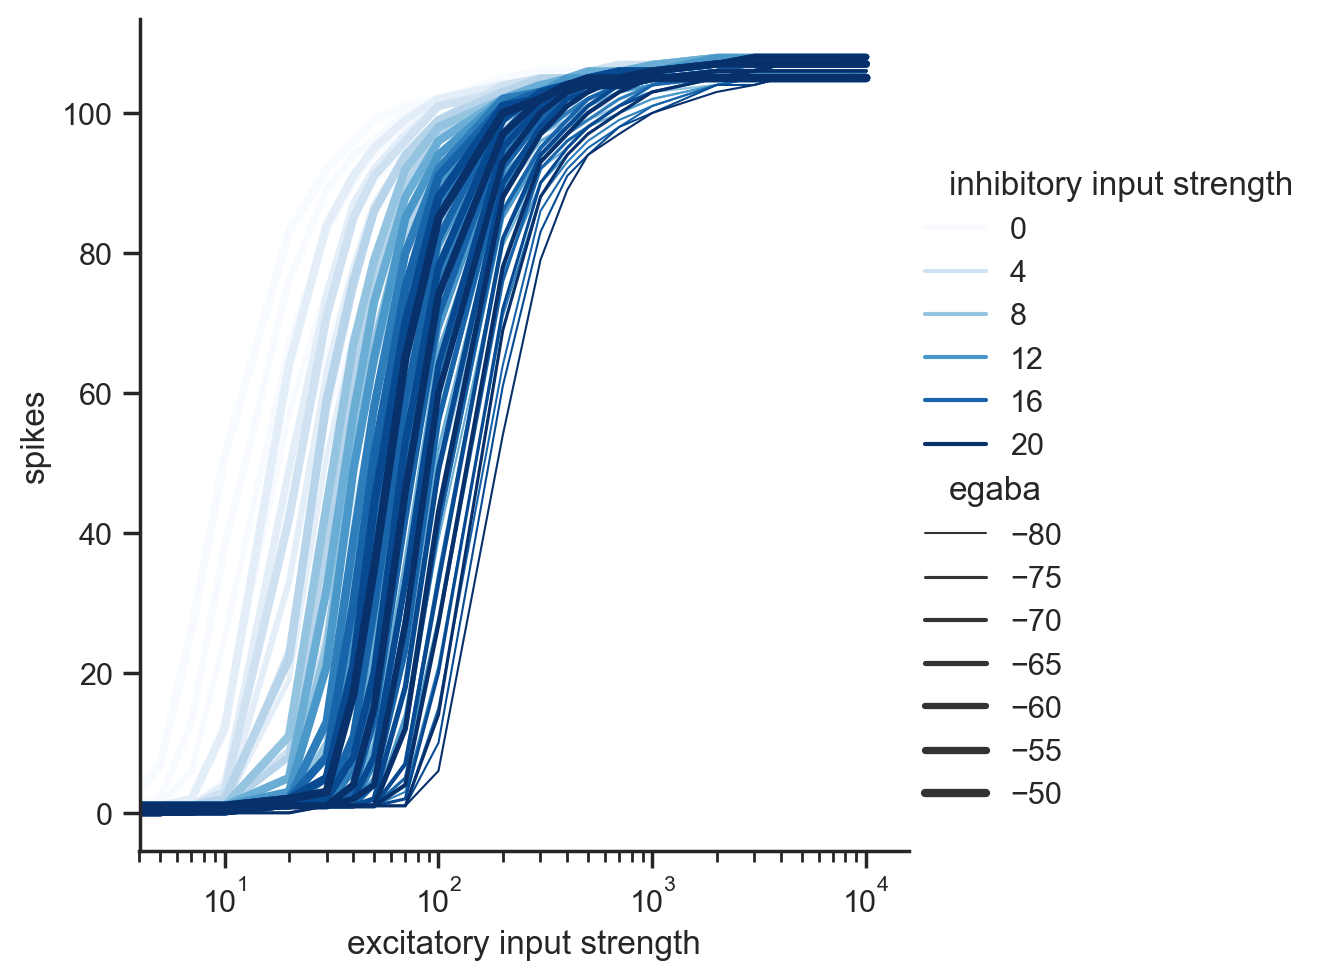

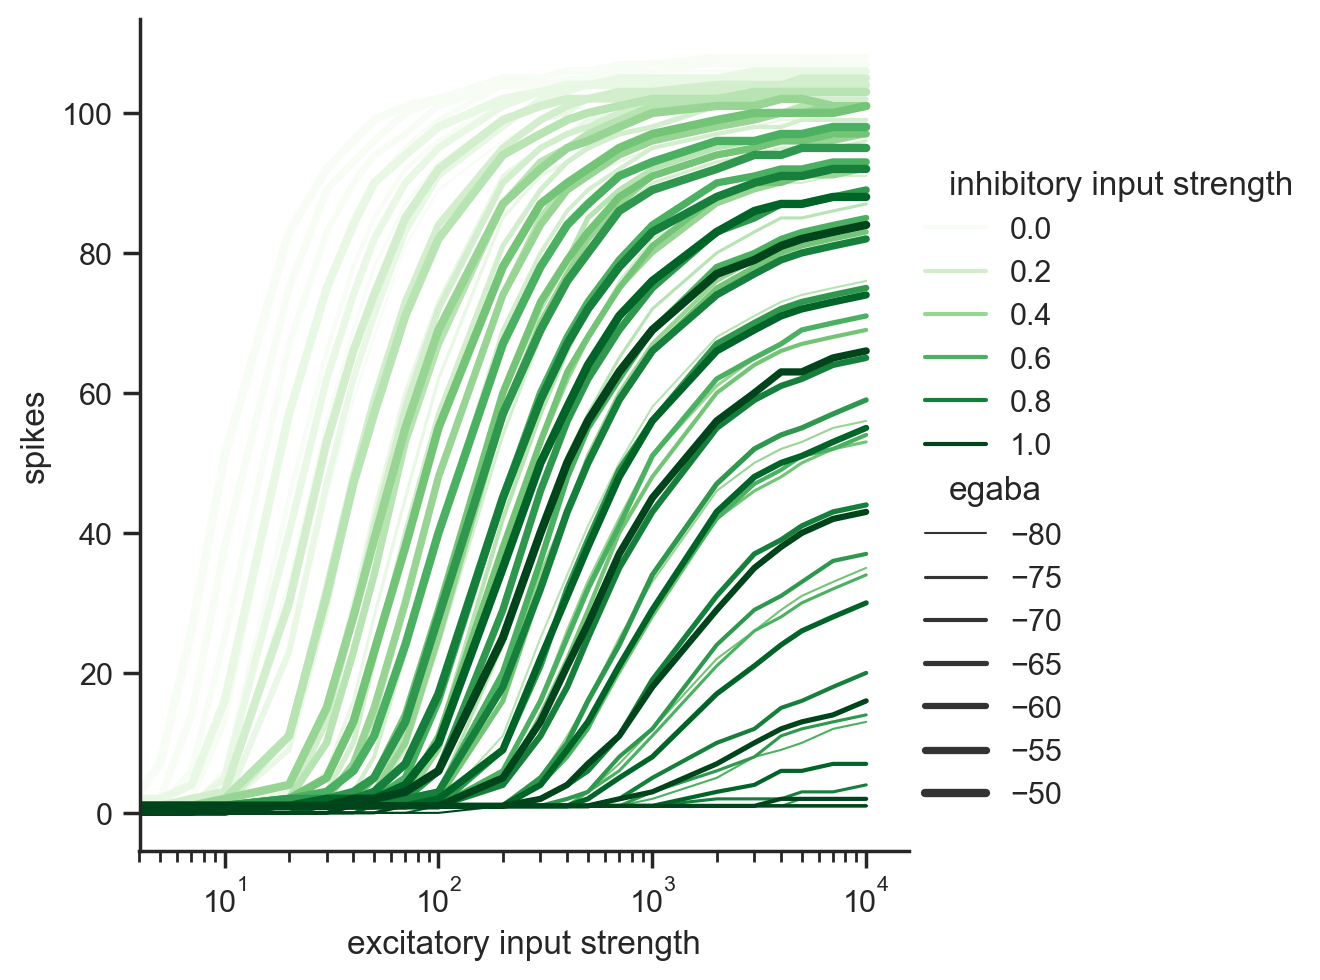

In [11]:
sns.set_theme(style="ticks")
sns.relplot(data=spikes[spikes["filename"]=="distal"], 
             x="excitatory input strength", 
             y="spikes", 
             hue="inhibitory input strength", 
             palette="Blues", 
             size="egaba",
             kind="line",
             )
plt.gca().set_xscale("log")
plt.gca().set_xlim(left=4)
sns.relplot(data=spikes[spikes["filename"]=="proximal"], 
             x="excitatory input strength", 
             y="spikes", 
             hue="inhibitory input strength", 
             palette="Greens", 
             size="egaba",
             kind="line",
             )
plt.gca().set_xscale("log")
plt.gca().set_xlim(left=4)

(10, 15848.93192461114)

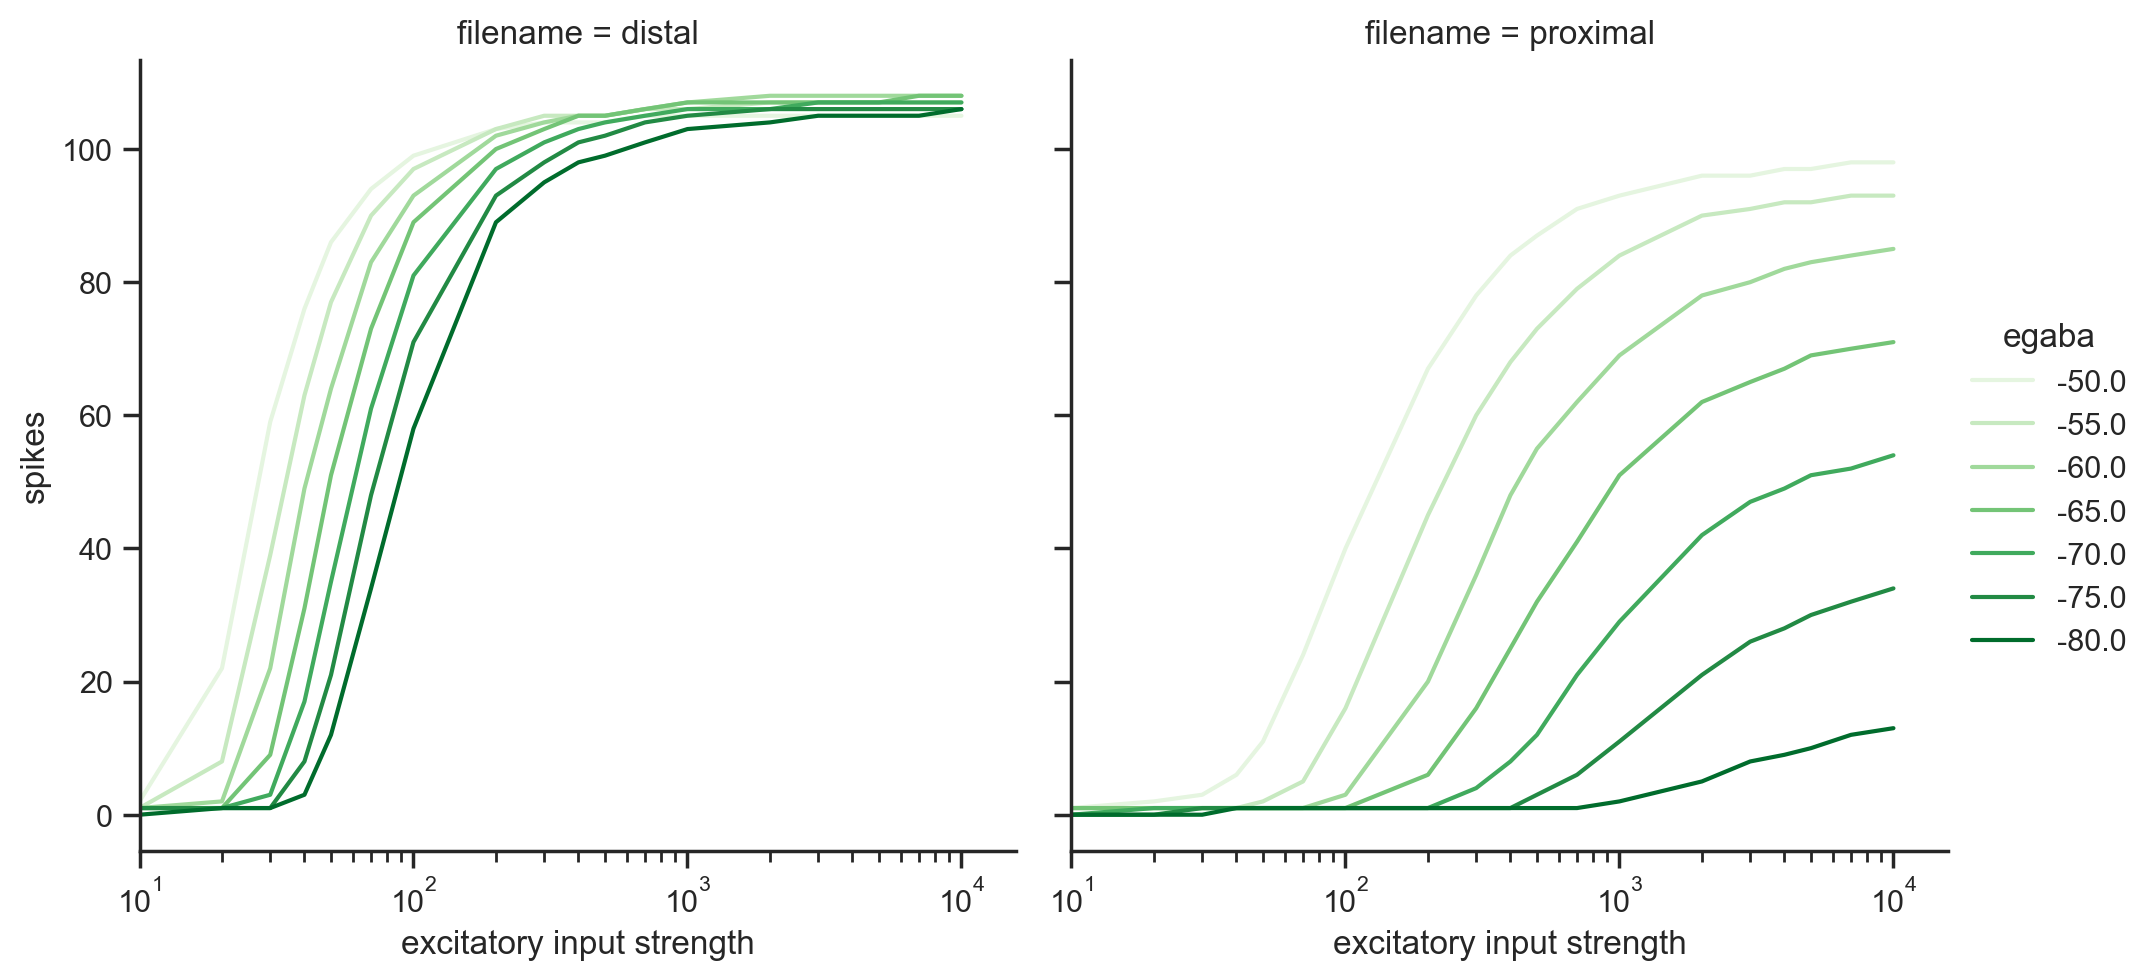

In [54]:
sns.relplot(data=spikes[spikes["inhibitory input strength"].isin([0.6, 6])], 
             x="excitatory input strength", 
             y="spikes", 
             hue="egaba", 
             hue_order=sorted(spikes["egaba"].unique(), reverse=True),
             palette=sns.color_palette("Greens", n_colors=len(spikes["egaba"].unique()), as_cmap=False), 
            #  row="egaba",
             col="filename",
             kind="line",
             )
plt.gca().set_xscale("log")
plt.gca().set_xlim(left=10)

Text(0.5, 1.0, 'EGABA = -65 mV')

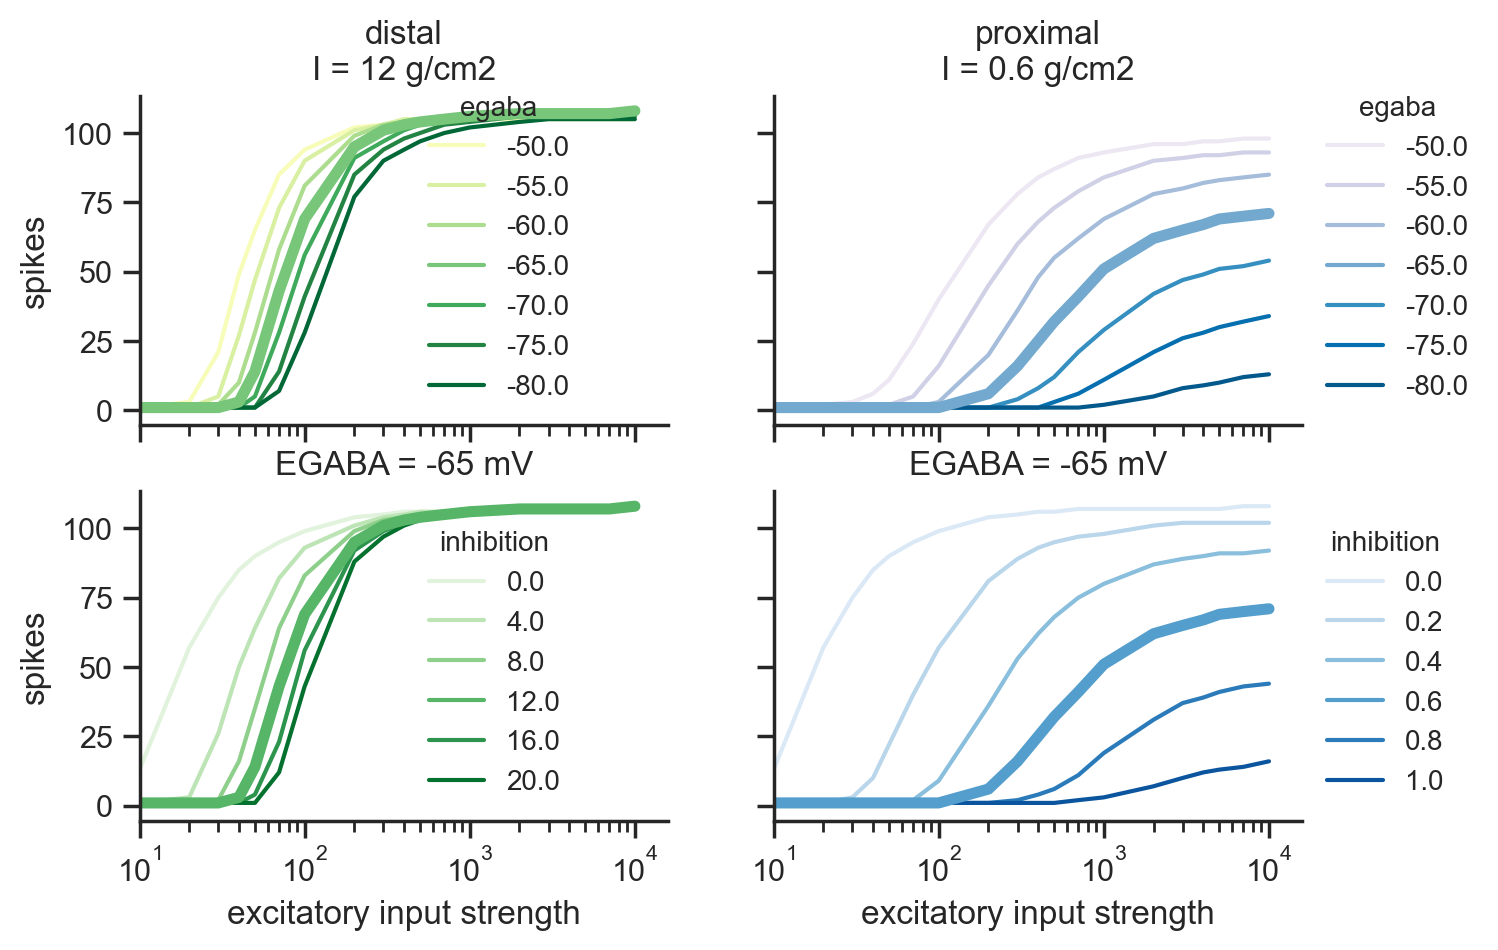

In [90]:
fig, axes = plt.subplot_mosaic([
    ["distal_I", "proximal_I"],
    ["distal_egaba", "proximal_egaba"],
    ], 
    sharey=True, sharex=True)
distal_spikes = spikes[spikes["filename"]=="distal"]
proximal_spikes = spikes[spikes["filename"]=="proximal"]
spikes_dict = {
    "distal": distal_spikes,
    "proximal": proximal_spikes,
}

i_strengths = {"proximal": 0.6, "distal": 12}

for f, ax in axes.items():
    f_dp, f_ei = f.split("_")
    _spikes = spikes_dict[f_dp]
    if f_ei == "egaba":
        all_i_strengths = _spikes["inhibitory input strength"].unique()[::2]
        pal = sns.color_palette("Greens" if f_dp=="distal" else "Blues", 
                n_colors=len(all_i_strengths), 
                as_cmap=False)
                
        sns.lineplot(data=_spikes[_spikes["egaba"]==-65], 
                    x="excitatory input strength", 
                    y="spikes", 
                    hue="inhibitory input strength", 
                    hue_order=all_i_strengths,
                    palette=pal, 
                    ax=ax,
                    # legend="brief",
                    )
        axes[f].legend(loc="lower left", frameon=False,
                    bbox_to_anchor=(0.5 + ("proximal" in f)/2, 0.0),
                    title="inhibition",
                    title_fontsize='small',
                    fontsize='small',
                    ncol=1,
                    )
    else:
        pal = sns.color_palette("YlGn" if f_dp=="distal" else "PuBu", 
                n_colors=len(_spikes["egaba"].unique()), 
                as_cmap=False)
        sns.lineplot(data=_spikes[_spikes["inhibitory input strength"].isin(i_strengths.values())], 
                    x="excitatory input strength", 
                    y="spikes", 
                    hue="egaba", 
                    hue_order=sorted(_spikes["egaba"].unique(), reverse=True),
                    palette=pal, 
                    ax=ax,
                    # legend="brief",
                    )
        axes[f].legend(loc="lower left", frameon=False,
                    bbox_to_anchor=(0.5 + ("proximal" in f)/2, 0.0),
                    title="egaba",
                    title_fontsize='small',
                    fontsize='small',
                    )

    sns.lineplot(data=_spikes[(_spikes["egaba"]==-65) & (_spikes["inhibitory input strength"]==i_strengths[f_dp])],
                    x="excitatory input strength",
                    y="spikes",
                    ax=ax,
                    color=pal[len(pal)//2],
                    # marker="o",
                    lw=4,
                    legend=False,
                    )
for ax in axes.values():
    ax.set_xscale("log")
    ax.set_xlim(left=10)
# fig.suptitle("EGABA = -65 mV")
sns.despine()
axes["distal_I"].set_title(f"distal\nI = {max(i_strengths.values())} g/cm2")
axes["proximal_I"].set_title(f"proximal\nI = {min(i_strengths.values())} g/cm2")
axes["distal_egaba"].set_title(f"EGABA = -65 mV")
axes["proximal_egaba"].set_title(f"EGABA = -65 mV")